<a href="https://colab.research.google.com/github/asimenia-akrivou/AsimeniaAkrivouThesis/blob/main/AkrivouAsimeniaThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

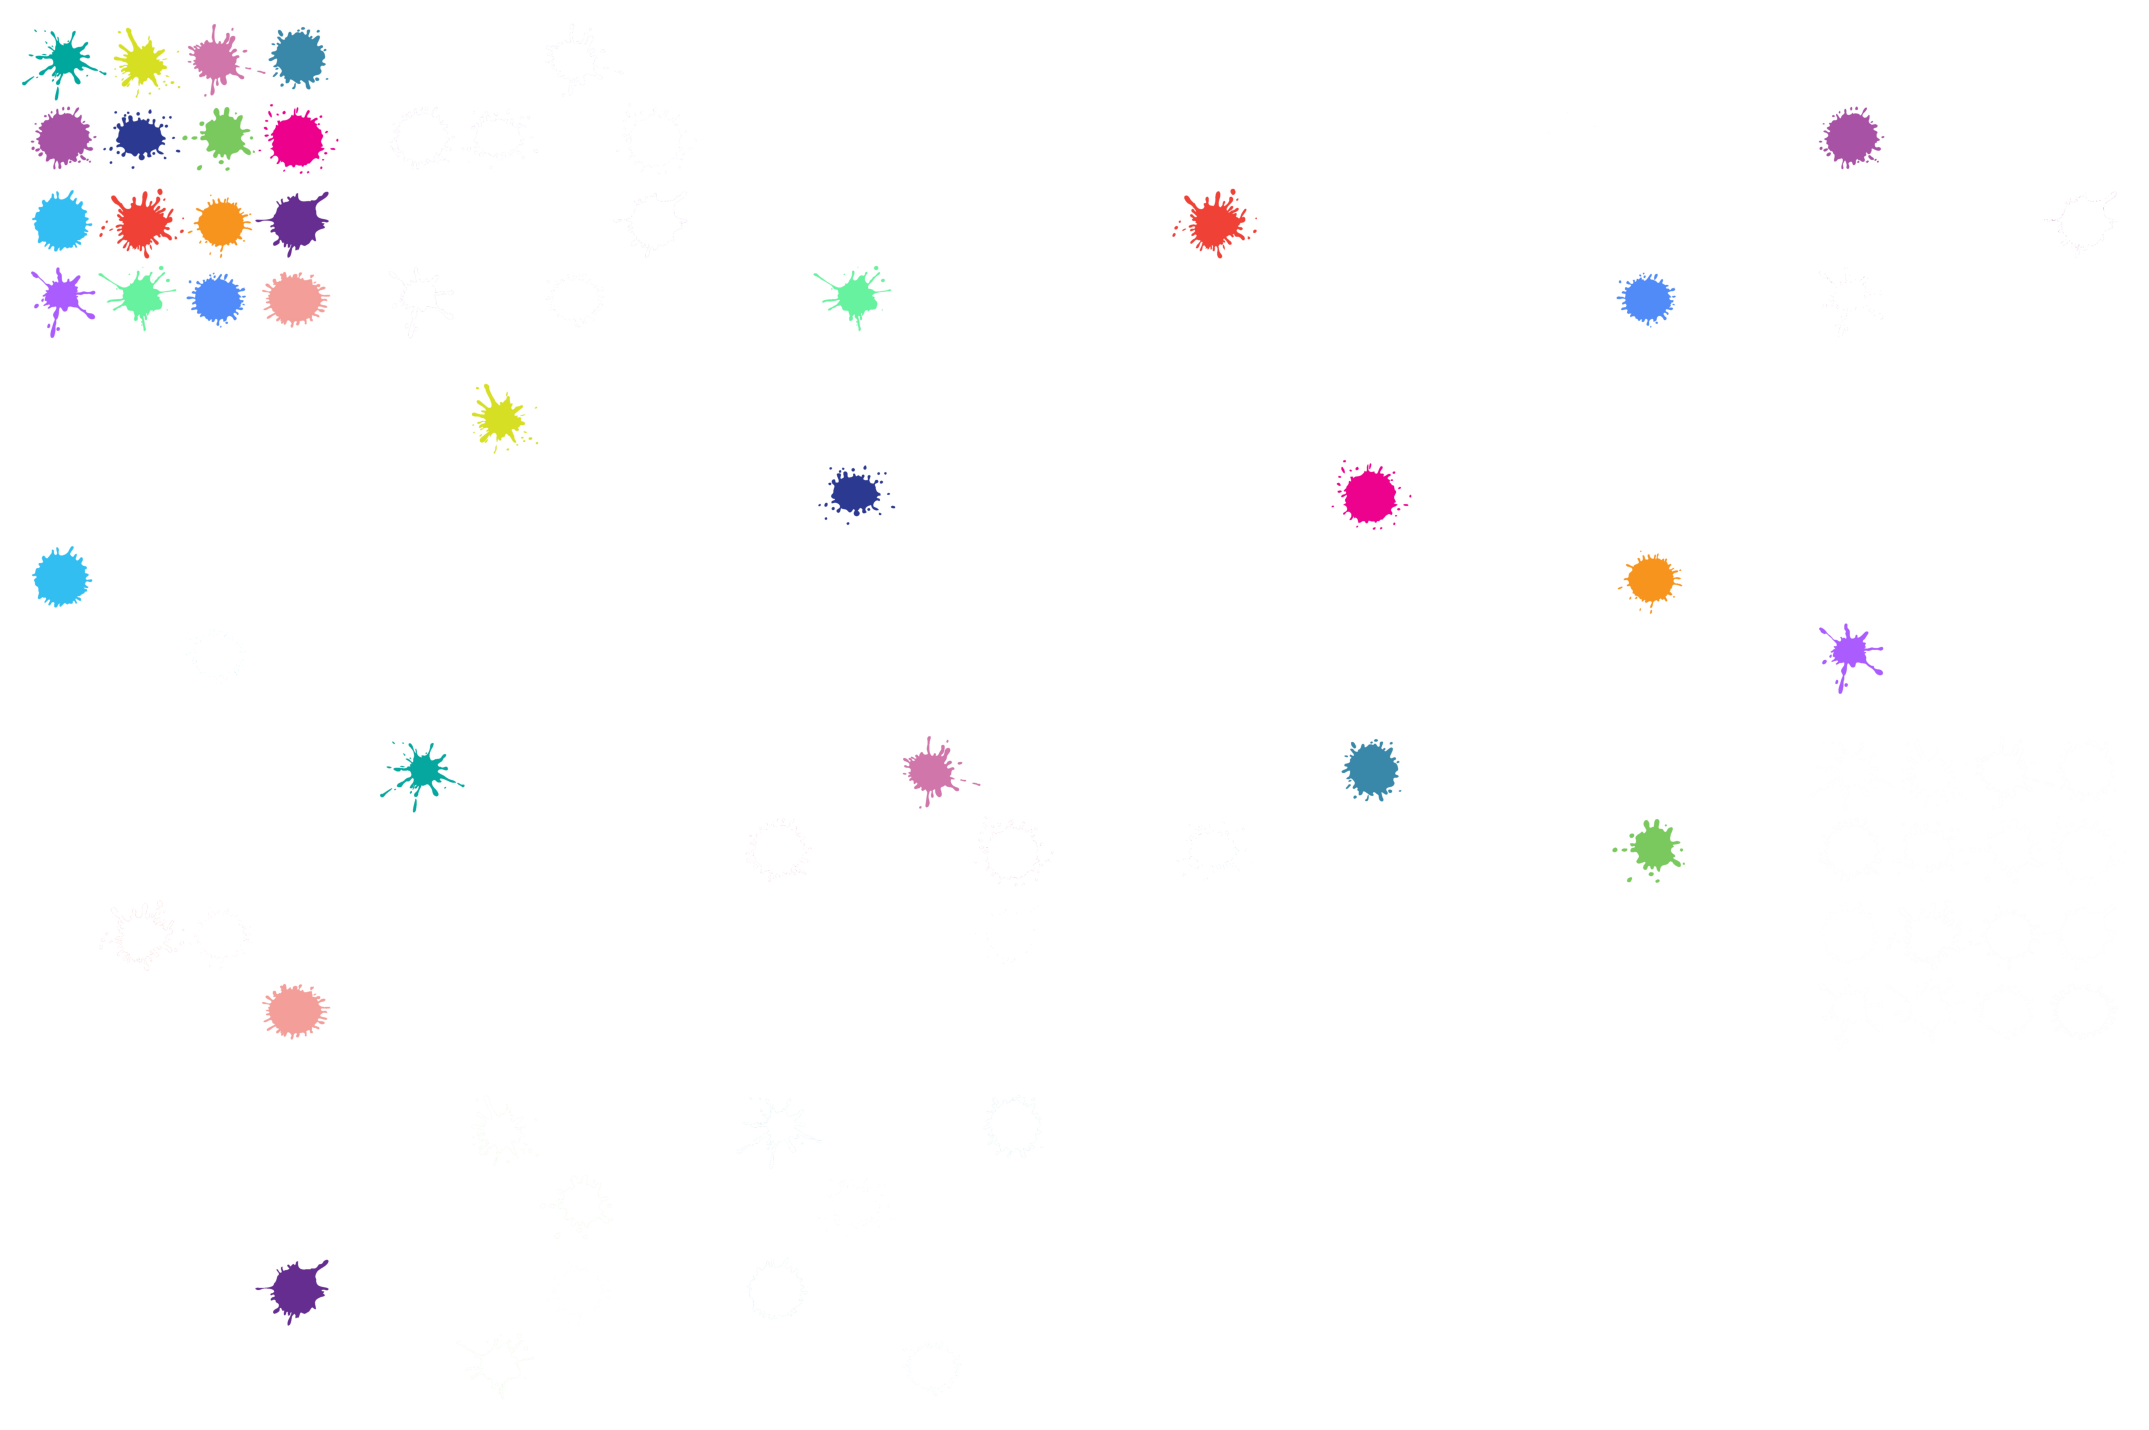

In [22]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io, os, gc, sys
from contextlib import redirect_stdout, redirect_stderr

# --- scikit-image ---
try:
    from skimage.morphology import disk, opening
    from skimage.morphology import remove_small_objects
except Exception:
    %pip -q install scikit-image
    from skimage.morphology import disk, opening
    from skimage.morphology import remove_small_objects

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

# ---------------- SETTINGS ----------------
K_FIXED = None
K_MIN, K_MAX = 2, 20
WHITE_THR = 248

EXTRA_DARK_LAYER = True
DARK_V = 0.25
DARK_S = 0.55
DARK_OPEN_RADIUS = 1
MIN_DARK_PIX = 8

BLACK_V   = 0.18
MIN_PIX   = 300
SAVE_PANELS = False  # disable file saving for pure visual output

AUTO_SAMPLE_MAX = 20000
FIT_SAMPLE_MAX  = 50000
KMEANS_MAX_ITER = 100
KMEANS_N_INIT   = 10
KMEANS_ALGO     = "elkan"
SILH_SAMPLE_SIZE = 5000

# ---------------- HELPER FUNCTIONS ----------------
def rgb_to_hsv(imgf):
    r,g,b = imgf[...,0], imgf[...,1], imgf[...,2]
    cmax = np.max(imgf, axis=-1); cmin = np.min(imgf, axis=-1)
    d = cmax - cmin + 1e-12
    h = np.zeros_like(cmax)
    m = d>0
    rm=(cmax==r)&m; gm=(cmax==g)&m; bm=(cmax==b)&m
    h[rm] = ((g-b)[rm]/d[rm])%6.0
    h[gm] = ((b-r)[gm]/d[gm])+2.0
    h[bm] = ((r-g)[bm]/d[bm])+4.0
    h = h/6.0
    s = np.zeros_like(cmax); s[cmax>0] = d[cmax>0]/cmax[cmax>0]
    v = cmax
    return h,s,v

def srgb_to_linear(c):
    c = c/255.0; a = 0.055
    return np.where(c<=0.04045, c/12.92, ((c+a)/(1+a))**2.4)

def linear_to_srgb(c):
    a = 0.055
    return np.where(c<=0.0031308, 12.92*c, (1+a)*np.power(c, 1/2.4)-a)

def rgb2lab(rgb):
    rgb = rgb.astype(np.float32, copy=False)
    r,g,b = srgb_to_linear(rgb[:,0]), srgb_to_linear(rgb[:,1]), srgb_to_linear(rgb[:,2])
    X = r*0.4124564 + g*0.3575761 + b*0.1804375
    Y = r*0.2126729 + g*0.7151522 + b*0.0721750
    Z = r*0.0193339 + g*0.1191920 + b*0.9503041
    Xn,Yn,Zn = 0.95047,1.0,1.08883
    x,y,z = X/Xn, Y/Yn, Z/Zn
    eps,kappa = 0.008856,903.3
    fx = np.where(x>eps, np.cbrt(x), (kappa*x+16)/116)
    fy = np.where(y>eps, np.cbrt(y), (kappa*y+16)/116)
    fz = np.where(z>eps, np.cbrt(z), (kappa*z+16)/116)
    L = 116*fy-16; a = 500*(fx-fy); b = 200*(fy-fz)
    return np.stack([L,a,b], axis=1).astype(np.float32, copy=False)

def lab2rgb(lab):
    L,a,b = lab[...,0], lab[...,1], lab[...,2]
    fy = (L + 16.0) / 116.0
    fx = fy + a/500.0
    fz = fy - b/200.0
    eps, kappa = 0.008856, 903.3
    x3 = fx**3; z3 = fz**3
    xr = np.where(x3>eps, x3, (116*fx-16)/kappa)
    yr = np.where(L>kappa*eps, ((L+16)/116.0)**3, L/kappa)
    zr = np.where(z3>eps, z3, (116*fz-16)/kappa)
    Xn,Yn,Zn = 0.95047,1.0,1.08883
    X = xr*Xn; Y = yr*Yn; Z = zr*Zn
    r =  3.2404542*X -1.5371385*Y -0.4985314*Z
    g = -0.9692660*X +1.8760108*Y +0.0415560*Z
    b =  0.0556434*X -0.2040259*Y +1.0572252*Z
    r = linear_to_srgb(np.clip(r, 0.0, 1.0))
    g = linear_to_srgb(np.clip(g, 0.0, 1.0))
    b = linear_to_srgb(np.clip(b, 0.0, 1.0))
    rgb = np.stack([r,g,b], axis=-1)*255.0
    return np.clip(rgb, 0, 255).astype(np.uint8, copy=False)

def to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

# ---------------- IMAGE INPUT (silent upload) ----------------
try:
    from google.colab import files
    with open(os.devnull, "w") as devnull, redirect_stdout(devnull), redirect_stderr(devnull):
        uploaded = files.upload()
    fname = next(iter(uploaded))
    im = Image.open(io.BytesIO(uploaded[fname])).convert("RGBA")
except Exception:
    im = Image.open("input.png").convert("RGBA")

# Composite RGBA over white background
bg = Image.new("RGBA", im.size, (255,255,255,255))
im = Image.alpha_composite(bg, im).convert("RGB")
img = np.asarray(im, dtype=np.uint8)
imgf = img.astype(np.float32)/255.0

# ---------------- WHITE & DARK MASKS ----------------
white = (img[...,0]>=WHITE_THR) & (img[...,1]>=WHITE_THR) & (img[...,2]>=WHITE_THR)
h,s,v = rgb_to_hsv(imgf)
dark_candidates = (v <= DARK_V) & (s <= DARK_S)
dark_clean = opening(dark_candidates, disk(DARK_OPEN_RADIUS))
dark_clean = remove_small_objects(dark_clean, min_size=MIN_DARK_PIX, connectivity=2)

keep_mask = ~white
if EXTRA_DARK_LAYER:
    keep_mask &= ~dark_clean

flat_keep = keep_mask.ravel()
coords = np.flatnonzero(flat_keep)
rgb_keep = img.reshape(-1,3)[coords]
lab_keep = rgb2lab(rgb_keep)

# ---------------- AUTO K SELECTION ----------------
def _eval_k(k, Xs):
    km = KMeans(
        n_clusters=k,
        n_init=KMEANS_N_INIT,
        max_iter=KMEANS_MAX_ITER,
        random_state=42,
        algorithm=KMEANS_ALGO
    ).fit(Xs)
    labels = km.labels_
    if len(np.unique(labels)) < 2:
        return (-1.0, k)
    sc = silhouette_score(
        Xs, labels,
        sample_size=min(SILH_SAMPLE_SIZE, Xs.shape[0]),
        random_state=42
    )
    return (sc, k)

if K_FIXED is None:
    n = lab_keep.shape[0]
    m = min(AUTO_SAMPLE_MAX, n)
    idx = np.random.default_rng(42).choice(n, m, replace=False)
    Xs = lab_keep[idx]
    if np.unique(Xs, axis=0).shape[0] < 2:
        K = 2
    else:
        upper = min(K_MAX, max(K_MIN+1, Xs.shape[0]-1))
        results = Parallel(n_jobs=-1, prefer="threads")(
            delayed(_eval_k)(k, Xs) for k in range(K_MIN, upper+1)
        )
        best_sc, best_k = max(results, key=lambda t: t[0])
        K = max(best_k, 2) if best_sc > -1 else 2
else:
    K = int(K_FIXED)

# ---------------- FIT & PREDICT ----------------
n_all = lab_keep.shape[0]
m_fit = min(FIT_SAMPLE_MAX, n_all)
idx_fit = np.random.default_rng(123).choice(n_all, m_fit, replace=False)
X_fit = lab_keep[idx_fit]

km = KMeans(
    n_clusters=K,
    n_init=KMEANS_N_INIT,
    max_iter=KMEANS_MAX_ITER,
    random_state=42,
    algorithm=KMEANS_ALGO
).fit(X_fit)

labels_keep = km.predict(lab_keep)

# ---------------- LAYER RECONSTRUCTION ----------------
h_img, w_img = img.shape[:2]
labels_full = np.full(h_img*w_img, -1, dtype=np.int32)
labels_full[coords] = labels_keep
labels_full = labels_full.reshape(h_img, w_img)

layers, meta = [], []
white_bg = np.full_like(img, 255, dtype=np.uint8)
centroid_rgb = lab2rgb(km.cluster_centers_.astype(np.float32)[None, :, :])[0]

for g in range(K):
    mask = (labels_full == g)
    area = int(mask.sum())
    if area < MIN_PIX:
        continue
    rep_rgb = centroid_rgb[g]
    out = white_bg.copy()
    out[mask] = rep_rgb
    layers.append(out)
    meta.append((area, to_hex(rep_rgb)))

if EXTRA_DARK_LAYER:
    dark_area = int(dark_clean.sum())
    if dark_area >= MIN_DARK_PIX:
        dark_layer = white_bg.copy()
        dark_layer[dark_clean] = img[dark_clean]
        layers.append(dark_layer)

# ---------------- SHOW ONLY FINAL IMAGE ----------------
cols = min(6, len(layers)+1)
rows = int(np.ceil((len(layers)+1) / cols))
plt.figure(figsize=(3.6*cols, 3.6*rows))
plt.subplot(rows, cols, 1); plt.imshow(img); plt.axis("off")
for i, layer in enumerate(layers, start=2):
    plt.subplot(rows, cols, i); plt.imshow(layer); plt.axis("off")
plt.tight_layout()
plt.show()

del km, lab_keep, rgb_keep
_ = gc.collect()